In [8]:
import tensorflow_core as tf
from matplotlib import pyplot as plt
import numpy as np

In [18]:
NUM_ITERS = 100

class SOM:
    def __init__(self, width, height, dim):
        self.num_iters = NUM_ITERS
        self.width = width
        self.height = height
        self.dim = dim
        self.node_locs = self.get_locs()

        nodes = tf.Variable(tf.random_normal([width * height, dim]))
        self.nodes = nodes

        x = tf.placeholder(tf.float32, [dim])
        iter = tf.placeholder(tf.float32)

        self.x = x
        self.iter = iter
        bmu_loc = self.get_bmu_loc(x)
        self.propagate_nodes = self.get_propagation(bmu_loc, x, iter)

    def get_propagation(self, bmu_loc, x, iter):
        num_nodes = self.width * self.height

        # calculate neural network hyperparameter
        def calculate_hyperparameter():
            rate = 1.0 - tf.divide(iter, self.num_iters)
            return (
                rate, rate * 0.5,
                rate * tf.to_float(tf.maximum(self.width, self.height)) / 2
            )
        _, alpha, sigma = calculate_hyperparameter()

        # calculate distance from BMUs base on location
        expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc), 0) 
        sqr_dists_from_bmu = tf.reduce_sum(
            tf.square(tf.subtract(expanded_bmu_loc, self.node_locs)), 1)

        # calculate neighbor factor
        neigh_factor = tf.exp(-tf.div(sqr_dists_from_bmu, 2 * tf.square(sigma)))

        # update nodes base on neighbor factor
        def update_nodes(): 
            rate = tf.multiply(alpha, neigh_factor)

            rate_factor = tf.stack([
                tf.tile(tf.slice(rate, [i], [1]),
                [self.dim]) for i in range(num_nodes)])
            
            nodes_diff = tf.multiply(
                rate_factor,
                tf.subtract(tf.stack([x for i in range(num_nodes)]), self.nodes))
            
            update_nodes = tf.add(self.nodes, nodes_diff)
            return tf.assign(self.nodes, update_nodes)

        return update_nodes()

    def get_bmu_loc(self, x):
        # expand dims to calculate distance to all neural nodes
        expanded_x = tf.expand_dims(x, 0)

        # calculate distance by weights
        sqr_diff = tf.square(tf.subtract(expanded_x, self.nodes))
        dists = tf.reduce_sum(sqr_diff, 1)

        # find shortest distance node index
        bmu_idx = tf.argmin(dists, 0)

        # convert index to 1 dimension location [x, y]
        bmu_loc = tf.stack([
            tf.mod(bmu_idx, self.width),
            tf.div(bmu_idx, self.width) # floor division
        ])
        return bmu_loc
    
    # an array of location
    # location is a 1 dimension array [x, y]
    def get_locs(self):
        locs = [
            [x, y]
                for y in range(self.height)
                for x in range(self.width)
        ]
        return tf.to_float(tf.convert_to_tensor(locs))

    def train(self, data):
        sess = tf.Session()
        init = (tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init)

        for i in range(self.num_iters):
            for data_x in data:
                sess.run(self.propagate_nodes, feed_dict={self.x: data_x, self.iter: i})

        # both output grid will do, just output different cluster order
        centroid_grid1 = [[] for i in range(self.width)] # output 2D grid base on width
        centroid_grid2 = [[] for i in range(self.height)] # output 2D grid base on height

        self.node_val = list(sess.run(self.nodes))
        self.locs_val = list(sess.run(self.node_locs))
        
        for i, l in enumerate(self.locs_val):
            centroid_grid1[int(l[0])].append(self.node_val[i])
            centroid_grid2[int(l[1])].append(self.node_val[i])
        
        self.centroid_grid = (centroid_grid1, centroid_grid2)


In [22]:
colors = np.array(
    [[0., 0., 1.],
    [0., 0., 0.95],
    [0., 0.05, 1.],
    [0., 1., 0.],
    [0., 0.95, 0.],
    [0., 1, 0.05],
    [1., 0., 0.],
    [1., 0.05, 0.],
    [1., 0., 0.05],
    [1., 1., 0.]])

som = SOM(4, 4, 3)
som.train(colors)

# plot data 
centroid_grid1, centroid_grid2 = som.centroid_grid

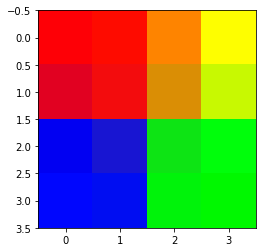

In [23]:
# grid base on width
plt.imshow(centroid_grid1)
plt.show()

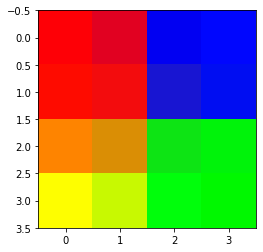

In [24]:
# grid base on height
plt.imshow(centroid_grid2)
plt.show()